In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

from fnmatch import fnmatch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from pattern import web

In [2]:
# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

In [3]:
def get_poll_xml(poll_id):
    inputStr = "http://charts.realclearpolitics.com/charts/%i.xml" % int(poll_id)
    return requests.get(inputStr).text


In [4]:
import re

def _strip(s):
    return re.sub(r'[\W_]+', '', s)

In [5]:
def plot_colors(xml):
    dom = web.Element(xml)
    result = {}
    for graph in dom.by_tag('graph'):
        title = _strip(graph.attributes['title'])
        result[title] = graph.attributes['color']
    return result

In [6]:
plot_colors(get_poll_xml(1171))

{u'Obama': u'#3B5998', u'Romney': u'#D30015'}

In [7]:
# import xml.etree.ElementTree as ET

# root = ET.fromstring(get_poll_xml(1171))

# for child in root:
#     print child.tag, child.attrib

In [8]:
def rcp_poll_data(xml):
#     myStr = get_poll_xml(1171)
#     dom = web.Element(myStr)
    dom = web.Element(xml)
    result = {}
    dates = dom.by_tag('series')[0]
    dates = {n.attributes['xid']: str(n.content) for n in dates.by_tag('value')}

    keys = dates.keys()

    result['date'] = pd.to_datetime([dates[k] for k in keys])

    for graph in dom.by_tag('graph'):
        name = graph.attributes['title']
        data = {n.attributes['xid']: float(n.content) if n.content else np.nan for n in graph.by_tag('value')}
        result[name] = [data[k] for k in keys]


    result = pd.DataFrame(result)
    result = result.sort(columns=['date'])
    
    return result

In [24]:
def poll_plot(poll_id):
    xml = get_poll_xml(poll_id)
    data = rcp_poll_data(xml)
    colors = plot_colors(xml)
    
    data = data.rename(columns = {c: _strip(c) for c in data.columns})
    
    norm = data[colors.keys()].sum(axis =  1) / 100
    
    for c in colors.keys():
        data[c] /= norm
    
    for label, color in colors.items():
        plt.plot(data.date, data[label], color=color, label = label)
    
    plt.xticks(rotation=70)
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Normalized Poll Percentage")  

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


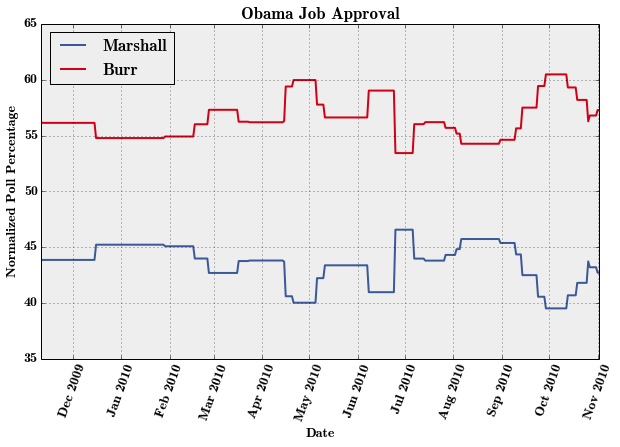

In [26]:
poll_plot(1111)
plt.title("Obama Job Approval")

In [ ]:
# def rcp_poll_data():

In [27]:
def is_gov_race(l):
    pattern = 'http://www.realclearpolitics.com/epolls/????/governor/??/*-*.html'
    return fnmatch(l, pattern)

In [28]:
def find_governor_races(html):
    dom = web.Element(html)
    links = [a.attributes.get('href', '') for a in dom.by_tag('a')] 
    links = [l for l in links if is_gov_race(l)]
    #eliminate duplicates!
    links = list(set(links))
    return links

In [29]:
page = requests.get('http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html').text.encode('ascii', 'ignore')

In [30]:
find_governor_races(page)

[u'http://www.realclearpolitics.com/epolls/2009/governor/va/virginia_governor_mcdonnell_vs_deeds-1055.html',
 u'http://www.realclearpolitics.com/epolls/2009/governor/nj/new_jersey_governor_corzine_vs_christie-1051.html']

In [31]:
p2 = requests.get("http://www.realclearpolitics.com/epolls/2009/governor/va/virginia_governor_mcdonnell_vs_deeds-1055.html").text.encode('ascii', 'ignore')

In [72]:
def race_result(url):
    
    dom = web.Element(requests.get(url).text)
    
    table = dom.by_tag('div#polling-data-rcp')[0]
    result_data = table.by_tag('tr.final')[0]
    td = result_data.by_tag('td')

    results = [float(t.content) for t in td[3:-1]]
    tot = sum(results) / 100
    
    #get table headers
    headers = table.by_tag('th')
    labels = [str(t.content).split('(')[0].strip() for t in headers[3:-1]]
    
    return {l:r / tot for l, r in zip(labels, results)}

In [73]:
race_result('http://www.realclearpolitics.com/epolls/2009/governor/va/virginia_governor_mcdonnell_vs_deeds-1055.html')

{'Deeds': 41.24124124124124, 'McDonnell': 58.75875875875875}

In [82]:
def id_from_url(url):
    """Given a URL, look up the RCP identifier number"""
    return url.split('-')[-1].split('.html')[0]


def plot_race(url):
    """Make a plot summarizing a senate race
    
    Overplots the actual race results as dashed horizontal lines
    """
    #hey, thanks again for these functions!
    id = id_from_url(url)
    xml = get_poll_xml(id)    
    colors = plot_colors(xml)

    if len(colors) == 0:
        return
    
    #really, you shouldn't have
    result = race_result(url)
    
    poll_plot(id)
    plt.xlabel("Date")
    plt.ylabel("Polling Percentage")
    for r in result:
        plt.axhline(result[r], color=colors[_strip(r)], alpha=0.6, ls='--')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


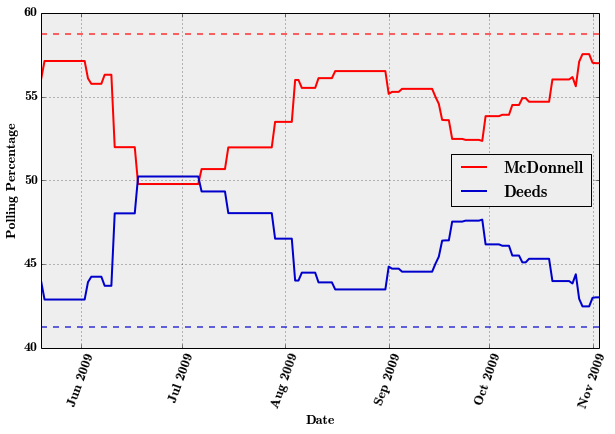

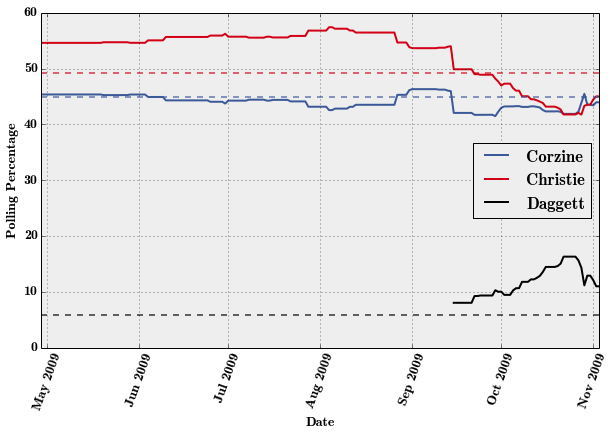

In [83]:
page = requests.get('http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html').text.encode('ascii', 'ignore')

for race in find_governor_races(page):
    plot_race(race)
    plt.show()